# Galaxy SED Fitting Using BAGPIPES
### CAM-SUST Summer School on Astrophysics 2025
<div style="display: flex; justify-content: flex-start; gap: 20px;">
    <img src="https://image2url.com/images/1757362010448-841fc1b0-c536-4424-ae6a-623df7f8fea7.png" 
         alt="Bagpipes Image" style="width: 20%;">
    <img src="https://cam-sust.org/images/cam-white.png" 
         alt="CAM Image" style="width: 20%;">
</div>

##### Instructor: Tanmoy Bhowmik

References:
1. Woods, P. BAGPIPES. Nat Astron 8, 1205 (2024). https://doi.org/10.1038/s41550-024-02360-2
2. A C Carnall, R J McLure, J S Dunlop, R Davé, Inferring the star formation histories of massive quiescent galaxies with bagpipes: evidence for multiple quenching mechanisms, Monthly Notices of the Royal Astronomical Society, Volume 480, Issue 4, November 2018, Pages 4379–4401, https://doi.org/10.1093/mnras/sty2169

## Steps Involved 
Workflow

1. Loads galaxy photometric data using load_goodss.

2. Prepares an SED fitting model with bagpipes.

3. Runs fits to derive galaxy properties (stellar mass, age, star formation history, etc.).

4. Plots results (SEDs, fits vs observed data).

# Loading observational data into Bagpipes

This session will show you how to input observational data. For further information see the [loading observational data](http://bagpipes.readthedocs.io/en/latest/loading_galaxies.html) page of the documentation.

## The load_data function

In order to load up data you need to write a function which accepts an ID (as a string) and returns your data in the format Bagpipes expects. 

For photometry this format is a nx2 array containing fluxes and flux errors in microJanskys. For spectroscopy this format is a nx3 array containing wavelengths in angstroms, fluxes and flux errors in ergs/s/cm^2/A.

Below is an example load data function for loading photometry from the [Guo et al. (2013) catalogue](https://archive.stsci.edu/prepds/candels). 

In [ ]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue. Multi-wavelength photometric catalog for the CANDELS (Cosmic Assembly Near-infrared Deep Extragalactic Legacy Survey) fields.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, #The code selects only the fluxes and flux errors needed for SED fitting (15 fluxes + 15 errors = 30 numbers).
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))  #usecols is just picking the right indices for the desired bands.
    
    # Find the correct row for the object we want.
    # The catalogue rows are numbered by ID starting at 1, but Python arrays are zero-indexed.
    # Subtracting 1 ensures you pick the right row.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    # Combines two 1D arrays (fluxes and errors) into a 2D array with shape (N_bands, 2).
    photometry = np.c_[fluxes, fluxerrs]   #So each row is [flux, flux_error] for one filter.

    # blow up the errors associated with any missing fluxes.
    # Some catalogue entries have no detection (flux = 0, or error ≤ 0).
    # Rather than ignoring them, the code assigns an enormous error (effectively infinite).
    #  This way, downstream fitting ignores that band without crashing.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):  # photometry[i, 0] == 0. → flux is zero (no detection).
            # photometry[i, 1] <= 0 → flux error is zero or negative (invalid).
            photometry[i,:] = [0., 9.9*10**99.]  # This ensures that downstream SED fitting codes like Bagpipes will effectively ignore this band.
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    # Photometric catalogs sometimes underestimate errors (especially for bright sources).
    for i in range(len(photometry)):
        # To avoid overfitting to a few very high-S/N points, the SNR is capped:
        # Max SNR = 20 for HST/ground-based bands.
        # Max SNR = 10 for IRAC (where systematics are worse).
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.

        # This is the signal-to-noise ratio (SNR) of band i.
        # photometry[i, 0] = flux
        # photometry[i, 1] = flux error
        if photometry[i, 0]/photometry[i, 1] > max_snr:  #If SNR exceeds max_snr, increase the flux error so the SNR = max_snr.
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

### Let's pick object 17433 as a test case to check this works.
A 2D array of shape (N_bands, 2). Each row: [flux, flux_error] for a band.
Bands with no detection or invalid errors get [0., 9.9e99].

Bands where SNR exceeds the cap have their errors inflated.


In [3]:
print(load_goodss("17433"))

[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]
 [0.000000e+00 9.900000e+99]
 [1.516060e+01 7.580300e-01]
 [2.142950e+01 1.071475e+00]
 [3.460530e+01 1.730265e+00]
 [3.460900e+01 3.460900e+00]
 [5.131500e+01 5.131500e+00]
 [3.950320e+01 3.950320e+00]
 [2.687740e+01 2.687740e+00]
 [1.799710e+01 1.799710e+00]]


All that's needed now is to pass the ID and load_goodss function to the bagpipes galaxy class, along with the filt_list.

As we're not inputting any spectroscopic data we'll also need to set the keyword argument spectrum_exists to "False".
1. This text file (goodss_filt_list.txt) contains the names (or transmission curves) of the filters corresponding to the photometry columns you selected in load_goodss.
2. Bagpipes needs this list so it knows which filters the fluxes correspond to when plotting or fitting.
3. "17433" → the galaxy ID, which load_goodss uses to grab the right row from the catalog.
4. load_goodss → your custom function that loads fluxes and errors into the required format.
5. spectrum_exists = False → you’re only fitting photometry, not a spectrum.
6. filt_list=goodss_filt_list → tells Bagpipes the filters associated with each photometric band.

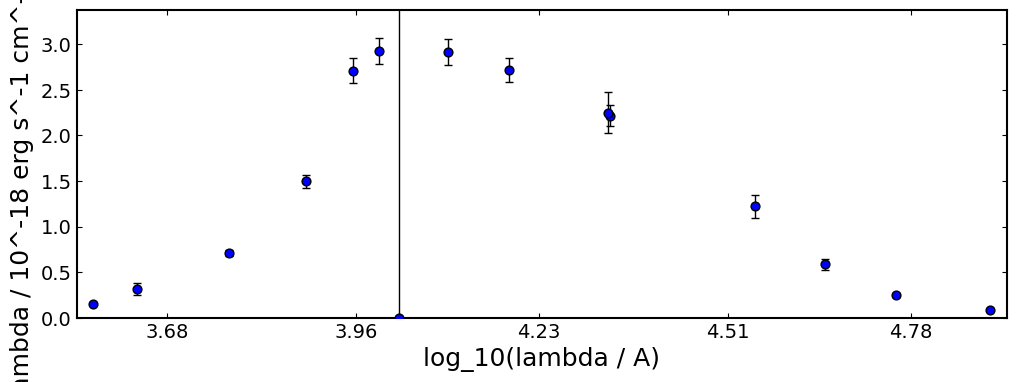

In [8]:
goodss_filt_list = np.loadtxt("goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
fig = galaxy.plot()
%matplotlib inline

That's about all there is to know, you can see that photometric points which fall within the wavelength range of the spectrum are plotted on the upper panel so you can see how well the calibration of the spectrum and photometry agrees.

# Fitting photometric data

This codes will take you through the basics of fitting photometric data. You can find further information on the [fitting observational data](http://bagpipes.readthedocs.io/en/latest/fitting_galaxies.html) page of the documentation.

## The fit instructions dictionary

Next we need to define the model we want to fit to the data. We do this by creating a [fit instructions dictionary](https://bagpipes.readthedocs.io/en/latest/fit_instructions.html). In many ways this is similar to the model components dictionary . However there are a few extra options for defining the parameters we wish to fit and the priors we wish to impose.  [A prior distribution is your assumption about the possible values of a parameter before you compare to the data.]

In [ ]:
# SFH component: exponential (τ-model)
# Bagpipes interprets this as a prior distribution for sampling during the fit.
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar


# Dust
dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust

Now we can pass the galaxy object and the fit_instructions dictionary into a fit object and run the Nautilus sampler to fit the data. 
* galaxy → contains the observed photometry (from load_goodss).
* fit_instructions → defines the parameter space (your priors for SFH, dust, redshift, etc.).
* This creates a fitting object that knows what data to compare and what models to generate.

In [ ]:
fit = pipes.fit(galaxy, fit_instructions)

MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 17433



  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Completed in 181.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.214      0.383      0.573
exponential:age                2.414      2.650      3.378
exponential:massformed        11.152     11.200     11.261
exponential:metallicity        0.601      1.018      1.469
exponential:tau                0.311      0.344      0.436
redshift                       0.946      0.992      1.036




## Run the fit
Runs the nested sampling algorithm (default: MultiNest) to explore parameter space.

* verbose=False suppresses the progress printout — useful if you don’t want screen spam.

The sampler will:
1. Generate trial galaxy models.
2. Compare them to the observed photometry.
3. Compute likelihoods and update the posterior distribution.

In [ ]:
fit.fit(verbose=False)

## Accessing posterior information

Samples from the posterior distribution for the fitted parameters are saved into the fit.posterior.samples dictionary. Some basic derived quantities are also calculated by default:


### Posterior Distribution in Bayesian Statistics

In Bayesian statistics, the **posterior** is:

$$
P(\theta \mid D) \propto P(D \mid \theta)\, P(\theta)
$$

where:

- $\theta$ = model parameters (e.g., redshift, age, tau, dust, metallicity, mass, …)  
- $D$ = your data (the observed GOODS-S photometry)  
- $P(D \mid \theta)$ = **likelihood** (how well a model explains the data)  
- $P(\theta)$ = **prior** (your allowed parameter ranges or distributions)  

---

 The **posterior distribution** is the probability distribution over parameters given your observed galaxy photometry.  

It tells you:  
- Which parameter values are most likely  
- How uncertain you are about them  
- How parameters are correlated (e.g., age–metallicity degeneracy)  



In [15]:
list(fit.posterior.samples)

['dust:Av',
 'exponential:age',
 'exponential:massformed',
 'exponential:metallicity',
 'exponential:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'mass_weighted_zmet',
 'sfh']

The first dimension of all of these arrays runs over the samples in the posterior.
* In Bagpipes, the stellar mass parameter is usually stored in the posterior as "exponential:massformed", not "stellar_mass" directly.

#### Median Advantages
* Robust to skewed distributions (less sensitive to outliers than the mean).
* Often better represents the “typical” value in astrophysical posteriors, which can be asymmetric.


If we want to know the posterior median living stellar mass we can write:

In [16]:
print(np.median(fit.posterior.samples["stellar_mass"]))

10.930900487652245


Or the posterior median specific star-formation rate:

In [ ]:
# Specific Star Formation Rate (sSFR) in Log-space
print(np.median(np.log10(fit.posterior.samples["sfr"]) - fit.posterior.samples["stellar_mass"]))

# fit.posterior.samples["sfr"] → array of star formation rate (SFR) posterior samples.
#  fit.posterior.samples["stellar_mass"] → array of stellar mass posterior samples.

-11.545827853514961


Or the confidence interval on the mass-weighted age:
### What it does:

* fit.posterior.samples["mass_weighted_age"]

This is a NumPy array of posterior samples for the mass-weighted age of the galaxy.

Each element is the mass-weighted age computed from one posterior draw.

* np.percentile(..., (16, 84))

Computes the 16th and 84th percentiles.

In [18]:
print(np.percentile(fit.posterior.samples["mass_weighted_age"], (16, 84)))

[2.1081782  2.91515719]


## Further posterior quantities

By default, samples for posterior quantities relating to the spectrum (e.g. posterior predictions for photometry, spectroscopy, rest-frame UVJ magnitudes etc) are not generated. These can be calculated using:

In [19]:
fit.posterior.get_advanced_quantities()
list(fit.posterior.samples)

['dust:Av',
 'exponential:age',
 'exponential:massformed',
 'exponential:metallicity',
 'exponential:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'mass_weighted_zmet',
 'sfh',
 'photometry',
 'spectrum_full',
 'uvj',
 'chisq_phot',
 'dust_curve']

##### Saving and loading posteriors
-----------------------------------
When a fit is finished, basic outputs needed to reconstruct the results of a fit are saved as a hdf5 file in the "pipes/posterior" directory. If this posterior file already exists when you create the fit object it'll automatically be loaded, and you won't be able to run the fit method again.

##### Steps
* Checks if a posterior exists,
* Loads it if present, or runs the fit if not,
* Then plots SED, SFH, and prints parameter summaries.


In [20]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Results loaded from pipes/posterior/./17433.h5

Fitting not performed as results have already been loaded from pipes/posterior/./17433.h5. To start over delete this file or change run.



If you want to start over just delete the posterior file. Alternatively, when you create your fit object, set the keyword argument "run" to some string, and this will start a brand new fit, the outputs of which will be saved in subfolders within pipes/posterior and pipes/plots with the same name as your run.

## Diagnostic plots

Bagpipes allows the creation of several standard diagnostic plots to visualise fitting results.

By default all of the plots one creates showing the fitting results are saved in the "pipes/plots" directory, here we will show them instead.

A corner plot (also called a triangle plot) shows the posterior probability distributions of all the fitted parameters in a grid of 1D and 2D histograms.

* 1D histograms along the diagonal → the marginal distribution of each parameter.

* Shows the range of values favored by the data.

* Example: Av might peak around 0.5 mag with some spread.



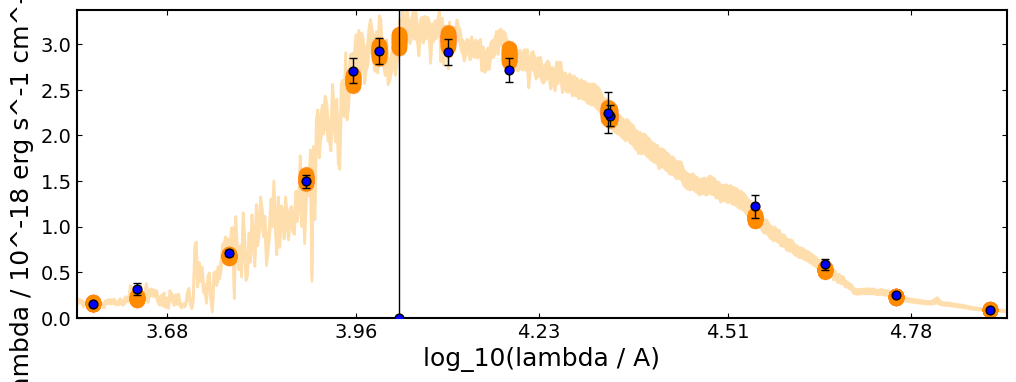

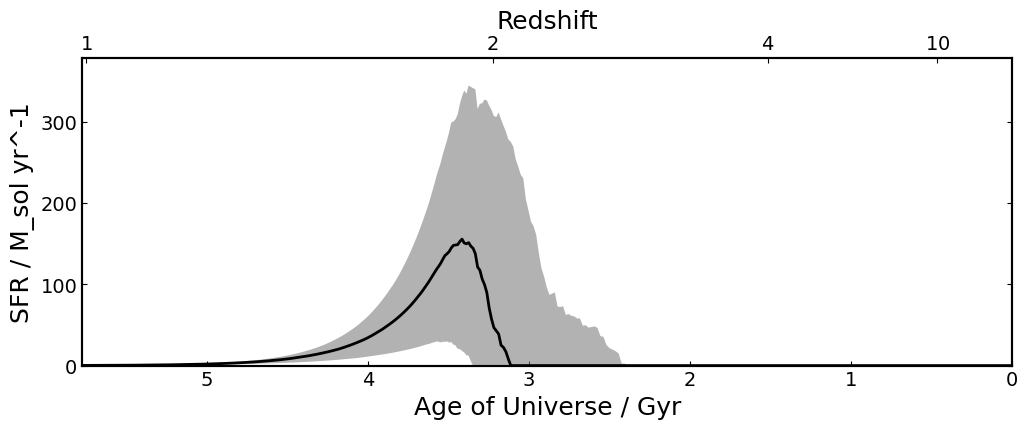

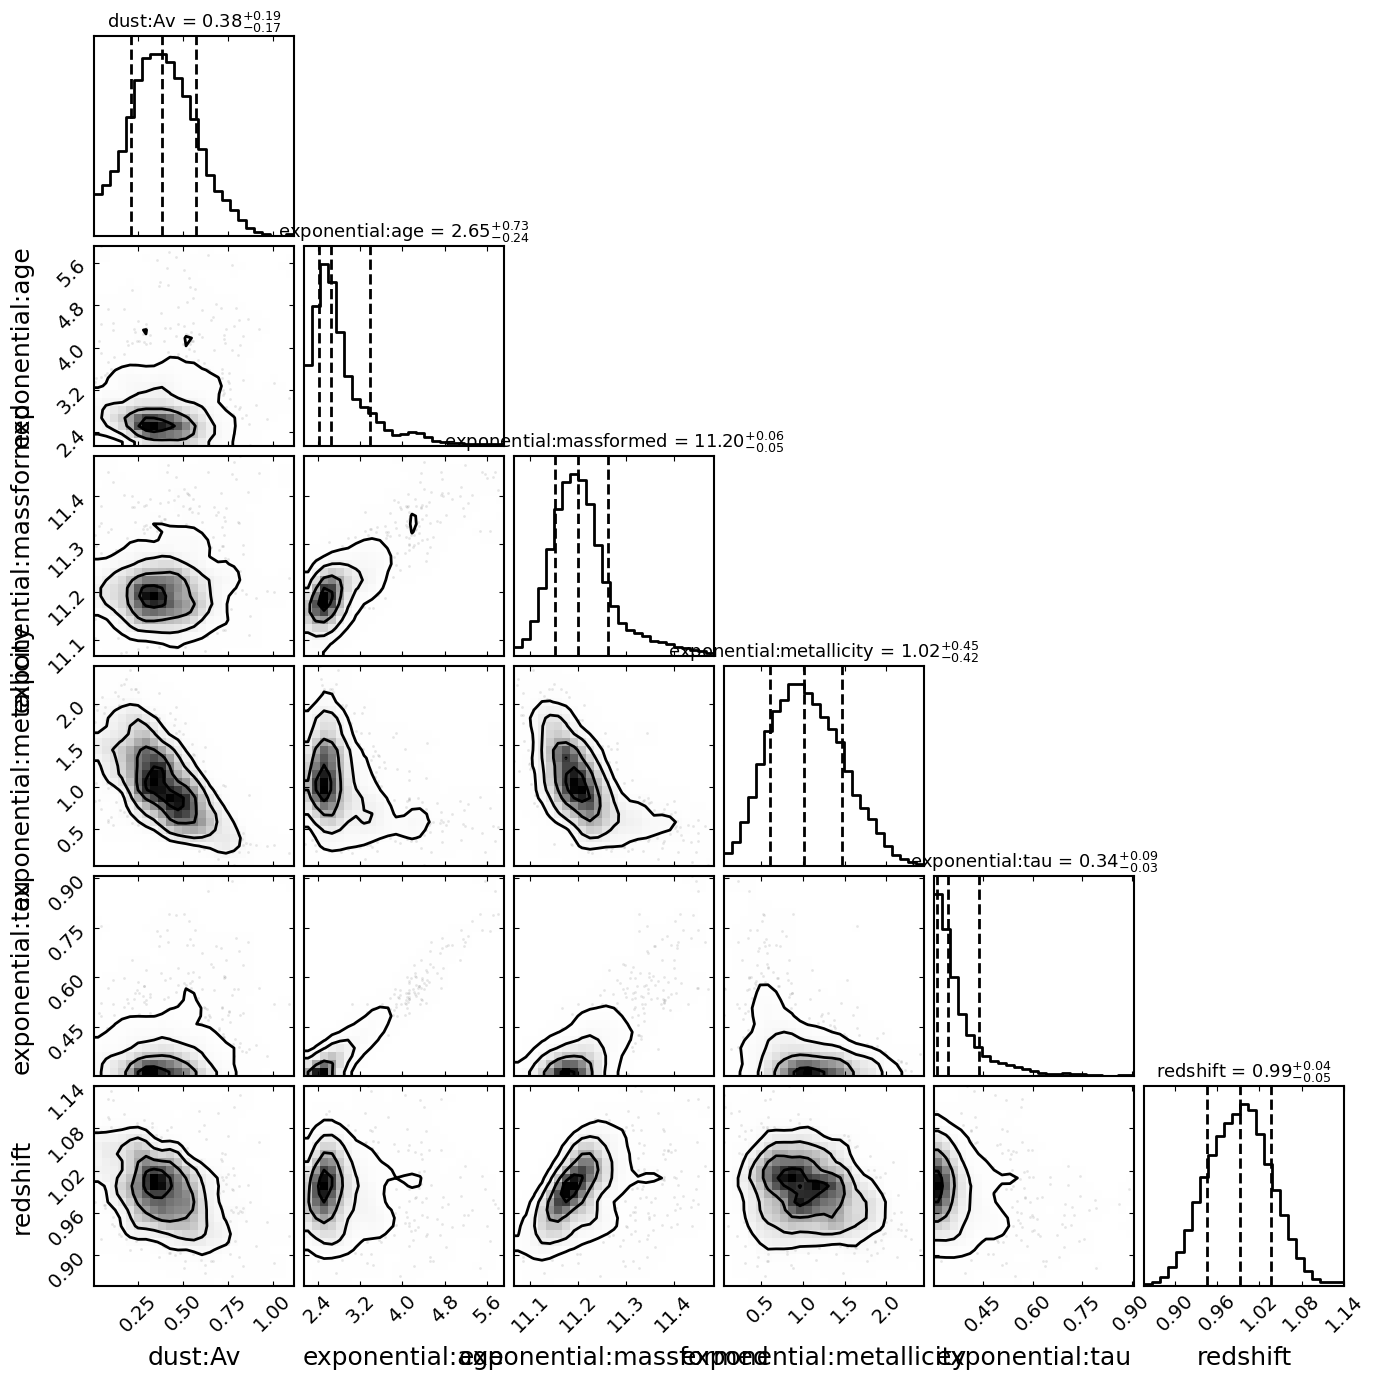

In [ ]:
fig = fit.plot_spectrum_posterior(save=True, show=True)
fig = fit.plot_sfh_posterior(save=True, show=True)
fig = fit.plot_corner(save=True, show=True)

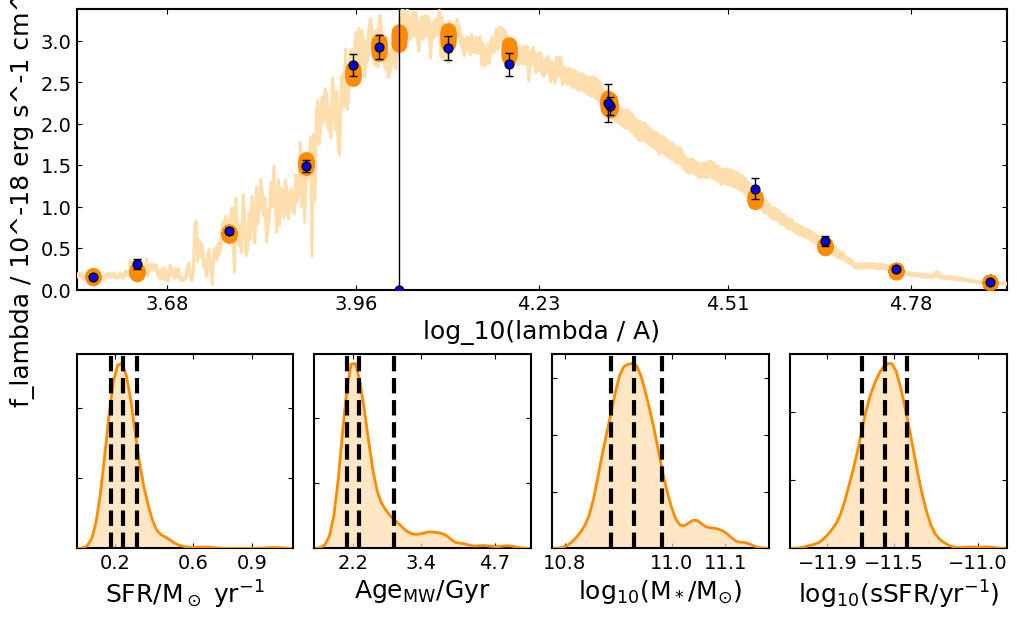

In [22]:
plt.close()

fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

ax1 = plt.subplot(gs[:4, :])

pipes.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
pipes.plotting.add_photometry_posterior(fit, ax1)

labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]

post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))

axes = []
for i in range(4):
    axes.append(plt.subplot(gs[4:, i]))
    pipes.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])

plt.show()

## “bagpipes”
## developed by A. C. Carnall - github.com/ACCarnall/bagpipes 
## Carnall+2018, Carnall+2019b